In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib 
import numpy as np
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D
import pyiast
plt.matplotlib.font_manager.fontManager.addfont("one_d_sensing/OpenSans-Regular.ttf")
plt.style.use("one_d_sensing/grandbudapest.mplstyle")
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import os
from sklearn import neighbors

# load in adsorption data
CO$_2$ and CH$_4$ adsorption in HKUST-1 and MOF-5 at 25 C

(source in .csv files)


In [21]:
mofs = ["HKUST-1", "IRMOF-1"]
gases = ["co2", "ch4"]
molecular_weight = {"ch4":16.04, "co2":44.01}
df = dict()
for mof in mofs:
    df[mof] = dict()
    for gas in gases:
        df[mof][gas] = pd.read_csv(os.path.join("adsorption_data", gas + "_" + mof + "_25C.csv"), skiprows = 1)
        if gas == "ch4":
            df[mof][gas]["N(mmol/g)"] = df[mof][gas]["N(cm3/g)"] / 22.4
        df[mof][gas]["N(g/g)"] = df[mof][gas]["N(mmol/g)"] * molecular_weight[gas] / 1000 

df["IRMOF-1"]["co2"]

,P(bar),N(mmol/g),N(g/g)
0,0.0,0.0,0.000000
1,1.2,1.1,0.048411
2,2.1,1.8,0.079218
3,3.2,2.8,0.123228
4,4.1,3.7,0.162837
5,5.3,4.9,0.215649
6,6.3,6.1,0.268461
7,7.2,7.1,0.312471
8,8.2,8.4,0.369684
9,9.4,10.1,0.444501


# Construct Adsorption Models
this is for `pyiast`

use interpolator isotherm for CO$_2$ in MOF-5 b/c of the inflection for which we do not have an analytical model.

note the IAST should be done on a mole basis.

In [22]:
gas_to_label = {"co2": "CO$_2$", "ch4": "CH$_4$"} # for latex
p_max_in_plot = {"co2": 50.0, "ch4": 100.0}
mof_to_color = {"IRMOF-1": "C0", "HKUST-1": "C3"}
gas_to_marker = {"co2": "s", "ch4": "o"}

In [23]:
ads_model = dict()
for mof in mofs:
    ads_model[mof] = dict()
    for gas in gases:
        if gas == "co2" and mof == "IRMOF-1":
            ads_model[mof][gas] = pyiast.InterpolatorIsotherm(df[mof][gas],
                                                              pressure_key="P(bar)",
                                                              loading_key="N(mmol/g)", 
                                                              fill_value=df[mof][gas]["N(mmol/g)"].max()) 
        else:
            ads_model[mof][gas] = pyiast.ModelIsotherm(df[mof][gas],
                                                       pressure_key="P(bar)",
                                                       loading_key="N(mmol/g)",
                                                       model="Langmuir")
      

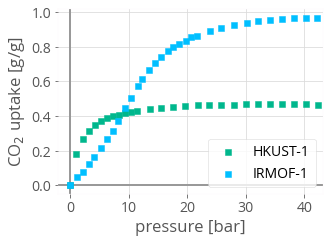

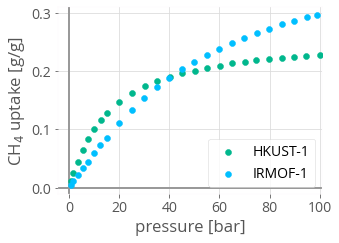

In [24]:
def draw_axes():
    plt.axvline(x=0, color="0.6", zorder=1)
    plt.axhline(y=0, color="0.6", zorder=1)

p_max = {"ch4": 101.0, "co2": 43.1}

for gas in gases:
    p = np.linspace(0.0, p_max[gas], 100)
    plt.figure(figsize=[6.4* 0.75, 4.8* 0.75])
    for mof in mofs:
        plt.scatter(df[mof][gas]["P(bar)"], df[mof][gas]["N(g/g)"], color=mof_to_color[mof], 
                    zorder=100, marker=gas_to_marker[gas], label=mof)
#         plt.plot(p, ads_model[mof][gas].loading(p) * molecular_weight[gas] / 1000, label=mof, color=mof_to_color[mof], zorder=100)
    draw_axes()
    plt.legend()
    plt.xlabel("pressure [bar]")
    plt.ylabel(gas_to_label[gas] + " uptake [g/g]")
    plt.tight_layout()
    plt.xlim(xmax=p_max[gas])
    plt.savefig(gas + "_adsorption_data.pdf", format="pdf") # in  mapping nb

In [25]:
ads_model["HKUST-1"]["co2"].params # e.g. get params

{'M': 11.258065277579124, 'K': 0.57196295270447}

In [26]:
ads_model["HKUST-1"]["co2"].loading(0.2) # e.g. compute loading at 0.2 bar

1.1556423315374746

# Adsorption model $\mathbf{m}=f(\mathbf{p})$

In [37]:
"""
    m = f(p)

return adsorbed mass in the MOFs as a function of pressure.

both m and p are arrays here.

m[i]: total mass adsorbed in MOF i
p[i]: partial pressure of gas i
"""
def f(p):
    if np.any(p < 0.0):
        return np.array([-10.0 * np.linalg.norm(p), -10.0 * np.linalg.norm(p)])
    m = np.zeros(2)
    for i, mof in enumerate(mofs):
        # if gas is pure gas 1
        if p[0] == 0.0:
            m[i] = ads_model[mof][gases[1]].loading(p[1]) * molecular_weight[gases[1]] / 1000
            continue
        #  if gas is pure gas 0
        if p[1] == 0.0:
            m[i] = ads_model[mof][gases[0]].loading(p[0]) * molecular_weight[gases[0]] / 1000
            continue
        # if reached this far, need IAST
        # first, a reasonable guess for adsorbed_mole_fraction_guess
        #  based on pure-component loadings
        m_guess = np.zeros(2)
        for g, gas in enumerate(gases):
            m_guess[g] = ads_model[mof][gas].loading(p[g])
        m_guess = m_guess / np.sum(m_guess)
        # component loadings in mof i.
        #  note that these are in mmol. so we need to use molecular weight to convert to g.
        q = pyiast.iast(p, [ads_model[mof][gas] for gas in gases],
                        verboseflag=False, adsorbed_mole_fraction_guess=m_guess, warningoff=True)
        for g, gas in enumerate(gases):
            m[i] += q[g] * molecular_weight[gas] / 1000
    return m # g/g
# turn warningoff=False to see if there are warnings.

In [38]:
p = np.array([5.0, 4.0])
m = f(p)
m

array([0.35548953, 0.23237338])

# Inverse of adsorption model $\mathbf{p}=g(\mathbf{m})$

## k-NN algo for good guess
forward function `f` is robust.

inverse function `g` is not... i.e. will not converge if the starting guess is not very close to the true solution.
so let's use nearest neighbors to get a good guess for the inverse function.

In [39]:
ps = np.linspace(0.0, 35.0, 100)
knn = neighbors.KNeighborsRegressor(1)
P = []
M = []
for i in range(len(ps)):
    for j in range(len(ps)):
        p = np.array([ps[i], ps[j]])
        P.append(p)
        M.append(f(p))
knn_model = knn.fit(M, P) # the inverse problem

def g_knn(m):
    return knn_model.predict([m])[0]

/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)


In [40]:
def distance_to_nearest_neighbor(m):
    return knn_model.kneighbors([m])[0][0][0]

In [41]:
g_knn(m)

array([4.94949495, 4.24242424])

In [42]:
"""
    p = g(m)

inverse of f(p). i.e. given m, return p that produces it.
if not a successful root finding, return Nans
"""
def g(m): 
    #  we want this function to return a zero vector
    #  it takes in a pressure p
    #  it outputs the corresponding difference between the response and the response m_0 that we find
    #  if we find the right p that gives us the response m_0, then this will be the zero vector
    def f_want_0(p):
        return f(p) - m
    p_guess = g_knn(m)
    sol = optimize.root(f_want_0, p_guess)
    p = sol.x
    # return nan if p less than lower bound, greater than upper bound
#     if p[0] < p_lb or p[1] < p_lb or p[0] > p_ub or p[1] > p_ub:
#         return np.array([np.nan, np.nan])
    if not sol.success:
        return np.array([np.nan, np.nan])
    return p

In [43]:
g(m)

array([5., 4.])

# Bivariate Color Map

In [34]:
def colorFromBivariateData(x, y):
    if np.any(x > 1) or np.any(y > 1):
        raise Exception("Numbers must be between 0 and 1.")
    if np.any(np.isnan(x)) or np.any(np.isnan(y)):
        return np.array([1, 1, 1, 1])
    return (x, y, 1-(x+y)/2, 1.0)

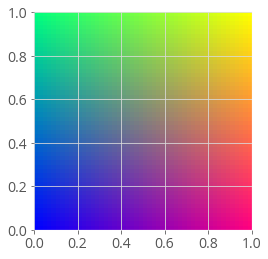

In [35]:
# Example of colorFromBivariateData function
x = np.linspace(0, 1)
y = np.linspace(0, 1)
z = [[colorFromBivariateData(x[i], y[j]) for i in range(np.size(x))] for j in range(np.size(y))]
extent = (0, 1, 0, 1) #figure out how to put our desired x/y lims on this
plt.imshow(z, extent=extent, origin='lower')

functions to draw grid lines

In [36]:
grid_line_color = "k"

# Functions to determine valid ranges of m1, m2

In [18]:
#f([0, pB], mof)

#### Functions to get valid m values to draw vertical grid lines ####
def find_pa_vert(m1): #find pa given that f_1([pa,0]) = m1
    return m1 / ((M1 - m1) * K1[0])

def find_pb_vert(m1): #find pb given that f_1([0, pb]) = m1
    return m1 / ((M1 - m1) * K1[1])

def find_pa_vert_pmax(m1): #find pa given that f_1([pa,p_max]) = m1
    return (m1 + m1*K1[1]*p_max - M1*K1[1]*p_max) / ((M1 - m1) * K1[0])

def find_pb_vert_pmax(m1): #find pb given that f_1([p_max, pb]) = m1
    return (m1 + m1*K1[0]*p_max - M1*K1[0]*p_max) / ((M1 - m1) * K1[1])

def valid_m2(m1): #find valid m2 value range for m1 
    pa = find_pa_vert(m1)
    pb = find_pb_vert(m1)   
    if pb > p_max and pa < p_max:
        m2_min = f([pa, 0])[1]
        m2_max = f([find_pa_vert_pmax(m1), p_max])[1]
    elif pb > p_max and pa > p_max:
        m2_min = f([p_max, find_pb_vert_pmax(m1)])[1]
        m2_max = f([find_pa_vert_pmax(m1), p_max])[1]
    else:
        m2_min = f([pa, 0])[1]
        m2_max = f([0, pb])[1]
    return m2_min, m2_max

In [19]:
#### Functions to get valid m values to draw horizontal grid lines ####
def find_pa_horizontal(m2): #find pa given that f_1([pa,0]) = m2
    return m2 / ((M2 - m2) * K2[0])

def find_pb_horizontal(m2): #find pb given that f_1([0, pb]) = m2
    return m2 / ((M2 - m2) * K2[1])

def find_pa_horizontal_pmax(m2): #find pa given that f_1([pa,p_max]) = m2
    return (m2 + m2*K2[1]*p_max - M2*K2[1]*p_max) / ((M2 - m2) * K2[0])

def find_pb_horizontal_pmax(m2): #find pb given that f_1([p_max, pb]) = m2
    return (m2 + m2*K2[0]*p_max - M2*K2[0]*p_max) / ((M2 - m2) * K2[1])

def valid_m1(m2): #find valid m1 value range for m2 
    pa = find_pa_horizontal(m2)
    pb = find_pb_horizontal(m2)   
    if pa > p_max and pb < p_max:
        m1_min = f_1([0, pb])
        m1_max = f_1([p_max, find_pb_horizontal_pmax(m2)])
    elif pa > p_max and pb > p_max:
        m1_min = f_1([find_pa_horizontal_pmax(m2), p_max])
        m1_max = f_1([p_max, find_pb_horizontal_pmax(m2)])
    else:
        m1_min = f_1([0, pb])
        m1_max = f_1([pa, 0])    
    return m1_min, m1_max

# Function to draw boundary on response space

In [74]:
# Function to draw boundary around response space figure
def draw_mspace_boundaries(p_max, plt_num):
    kwargs = {"color": grid_line_color, "lw": 3, "clip_on": False, "zorder": 100}
    x = np.linspace(0, p_max, 100)
    m1 = np.zeros(len(x))
    m2 = np.zeros(len(x))
    for i in range(len(x)):
        # make pa = 0
        p = np.array([0, x[i]])
        m1[i], m2[i] = f(p) 
    ax[plt_num].plot(m1, m2, **kwargs)
    for i in range(len(x)):        
        # make pb = 0
        p = np.array([x[i], 0])
        m1[i], m2[i] = f(p) 
    ax[plt_num].plot(m1, m2, **kwargs)
    for i in range(len(x)):        
        # make pa = max
        p = np.array([p_max, x[i]])
        m1[i], m2[i] = f(p) 
    ax[plt_num].plot(m1, m2, **kwargs)
    for i in range(len(x)):        
        # make pb = max
        p = np.array([x[i], p_max])
        m1[i], m2[i] = f(p) 
    ax[plt_num].plot(m1, m2, **kwargs)
    
def draw_box(L, plt_num):
    kwargs = {"color": grid_line_color, "lw": 3, "clip_on": False, "zorder": 100}
    ax[plt_num].hlines(0.0, 0.0, L, **kwargs)
    ax[plt_num].hlines(L  , 0.0, L, **kwargs)
    ax[plt_num].vlines(0.0, 0.0, L, **kwargs)
    ax[plt_num].vlines(L  , 0.0, L, **kwargs)

In [75]:
# def f_test(x, y):
#     return x

# x = np.linspace(0, 2.0, 5)
# y = np.linspace(0.0, 10.0, 100)
# z = [[plt.cm.Greens(f_test(x_i, y_i)) for x_i in x] for y_i in y]
# plt.figure()
# extent = (0, 2.0, 0, 10.0)
# plt.imshow(z, extent=extent, origin='lower')

# composition $\rightarrow$ response space mapping by $f(\mathbf{p})$.
(forward problem) $f : \mathbf{p} \mapsto \mathbf{m}$

doing kNN inverse, not the real inverse!


/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: inval

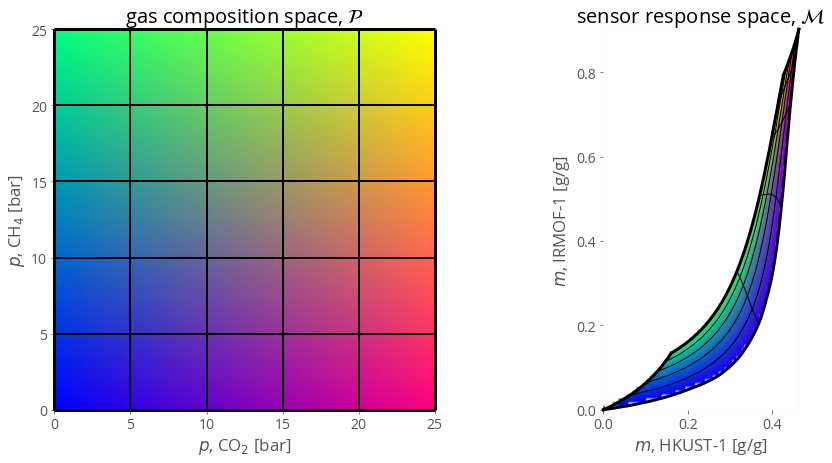

In [89]:
p_max = 25.0

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# turn off grid.
for k in range(2):
    ax[k].grid(False)
    
###
#   composition space. color is uniform here.
###
ax[0].set_title("gas composition space, $\mathcal{P}$")
ax[0].set_xlabel("$p$, " + gas_to_label[gases[0]] + " [bar]")
ax[0].set_ylabel("$p$, " + gas_to_label[gases[1]] + " [bar]")

p = np.linspace(0, p_max, 100)
z = [[colorFromBivariateData(p_x / p_max, p_y / p_max) for p_x in p] for p_y in p]
ax[0].imshow(z, extent=(0, p_max, 0, p_max), origin='lower')     
ax[0].set_aspect('equal', 'box')
draw_box(p_max, 0)

###
#   sensor response space
###
ax[1].set_title("sensor response space, $\mathcal{M}$")
ax[1].set_xlabel("$m$, " + mofs[0] + " [g/g]")
ax[1].set_ylabel("$m$, " + mofs[1] + " [g/g]")

# see how big we need to go in m.
#    look at corners
m_corners = [f(np.array([p_max, 0.0])), f(np.array([p_max, p_max])), f(np.array([0.0, p_max]))]
m0_max = np.max([m_corner[0] for m_corner in m_corners])
m1_max = np.max([m_corner[1] for m_corner in m_corners])

num_grid_pts = 100
m0_grid = np.linspace(0, m0_max, num_grid_pts)
m1_grid = np.linspace(0, m1_max, num_grid_pts)

z = [[colorFromBivariateData(np.nan, np.nan) for i in range(num_grid_pts)] for j in range(num_grid_pts)]

da_real_thing = True
if ~ da_real_thing:
    print("doing kNN inverse, not the real inverse!")
for i in range(num_grid_pts):
    for j in range(num_grid_pts):
        m = np.array([m0_grid[i], m1_grid[j]])
        # use k-NN approx to the inverse to rule out points safely far from boundary
        if distance_to_nearest_neighbor(m) > 0.05:
            continue
#         if np.any(p > 1.5 * p_max) or np.any(p < 0.0):
#             continue
        # now do the real inverse
        if da_real_thing:
            p = g(m)
        else:
            p = g_knn(m)
        if np.any(np.isnan(p)):
            continue
        if np.all(p < p_max):
            z[j][i] = colorFromBivariateData(p[0] / p_max, p[1] / p_max)

ax[1].imshow(z, extent=(0, m0_max, 0, m1_max),  origin='lower') 
ax[1].set_aspect('equal', 'box')

###
#  grid lines
###
nb_lines = 6
nb_pts = 50
ps = np.linspace(0, p_max, nb_lines)
p_fine = np.linspace(0, p_max, nb_pts)
for i in range(len(ps)):
    ###
    #   x = constant (vertical) grid lines
    ###
    p_a = ps[i] # p_a is constant here.
    ax[0].vlines(p_a, 0, p_max, color=grid_line_color)
    
    # plot the image of the line in sensor response space
    #     loop through points on the line
    m0 = np.zeros(nb_pts)
    m1 = np.zeros(nb_pts)
    for j, p_b in enumerate(p_fine):
        p = np.array([p_a, p_b])
        m0[j], m1[j] = f(p)
    ax[1].plot(m0, m1, color=grid_line_color, lw=1)
    
    ###
    #   y = constant (horizontal) grid lines
    ###
    p_b = ps[i] # p_b is constant here.
    ax[0].hlines(p_b, 0, p_max, color=grid_line_color)
    
    # plot the image of the line in sensor response space
    # loop through points on the line
    for j, p_a in enumerate(p_fine):
        p = np.array([p_a, p_b])
        m0[j], m1[j] = f(p)
    ax[1].plot(m0, m1, color=grid_line_color, lw=1)

draw_mspace_boundaries(p_max, 1)
plt.savefig("p_to_m_2d.pdf", format="pdf")

# Mapping Response Space to Composition Space

# Conditionining

In [86]:
import numdifftools as nd

J_f = nd.Jacobian(f) # a function!

In [87]:
def condition_no(p):
    j = J_f(p) # Jacobian of f(p) at p
    return 1 / np.min(np.linalg.svd(j)[1]) # operator norm of inverse of j = J_g(m)

/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["K"] * pressure)
/usr/local/lib/python3.6/dist-packages/pyiast/isotherms.py:351: RuntimeWarning: inval

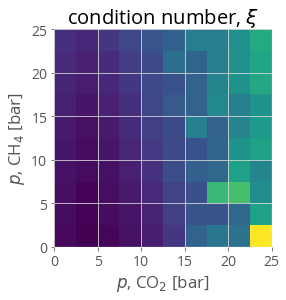

In [88]:
p_max = 25.0
ps = np.linspace(0.01, p_max, 10)
z = [[condition_no(np.array([p_x, p_y])) for p_x in ps] for p_y in ps]

plt.figure()
plt.title("condition number, $\\xi$")
plt.xlabel("$p$, " + gas_to_label[gases[0]] + " [bar]")
plt.ylabel("$p$, " + gas_to_label[gases[1]] + " [bar]")
plt.imshow(z, origin="lower", extent=(0, p_max, 0, p_max))